In this post we will look at the momentum strategy from Andreas F. Clenow's book [Stocks on the Move: Beating the Market with Hedge Fund Momentum Strategy](https://amzn.to/2YzEIvL) and backtest its performance using the survivorship bias-free dataset we created in my [last post](/2019/05/creating-a-survivorship-bias-free-sp-500-dataset-with-python/).

Momentum strategies are almost the opposite of mean-reversion strategies. A typical momentum strategy will buy stocks that have been showing an upward trend in hopes that the trend will continue. The momentum strategy defined in Clenow's books trades based upon the following rules:

 * Trade once a week. In his book, Clenow trades every Wednesday, but as he notes, which day is completely arbitrary.
 
 
 * Rank stocks in the S&P 500 based on momentum. Momentum is calculated by multiplying the annualized exponential regression slope of the past 90 days by the $R^2$ coefficient of the regression calculation.
 
 
 * Position size is calculated using the 20-day [Average True Range](https://www.investopedia.com/terms/a/atr.asp) of each stock, multiplied by 10 basis points of the portfolio value.
 
 
 * Only open new positions if the S&P 500 is above its 200-day moving average.
 
 
 * Every week, look to sell stocks that are not in the top 20% momentum ranking, or have fallen below their 100 day moving average. Buy stocks in the top 20% momentum rankings with remaining cash.
 
 
 * Every other week, rebalance existing positions with updated Average True Range values.

Before we backtest the strategy, let's look into the momentum and position size formulas.

## Momentum

As mentioned above, momentum is calculated by multiplying the annualized exponential regression slope of the past 90 days by the $R^2$ coefficient of the regression calculation. To see this in action, let's look at the highest momentum values measured in our dataset. First we'll need to load in the dataset:

In [1]:
from datetime import datetime 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
plt.ioff()

In [25]:
import os
os.getcwd()
dir = os.path.join(os.getcwd(), 'survivorship_free')
print(dir)

/content/survivorship_free


In [26]:
tickers = pd.read_csv(f'{dir}/tickers.csv')['ticker'].tolist()
stocks = (
    (pd.concat(
        [pd.read_csv(f'{dir}/data/{ticker}.csv', index_col='date', parse_dates=True)[
            'close'
        ].rename(ticker)
        for ticker in tickers],
        axis=1,
        sort=True)
    )
)
stocks = stocks.loc[:,~stocks.columns.duplicated()]

Now let's create our momentum measurement function. We can compute the exponential regression of a stock by performing linear regression on the natural log of the stock's daily closes:

In [27]:
from scipy.stats import linregress
def momentum(closes):
    returns = np.log(closes)
    x = np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x, returns)
    return ((1 + slope) ** 252) * (rvalue ** 2)  # annualize slope and multiply by R^2

Now we can apply a rolling 90 day momentum calculation to all of the stocks in our universe:

In [28]:
momentums = stocks[:-89].copy(deep=True)
for ticker in tickers:
    momentums[ticker] = stocks[ticker][:-89].rolling(90).apply(momentum, raw=False)

Let's look at the 5 stocks with the best momentum values and plot them along with their regression curve.

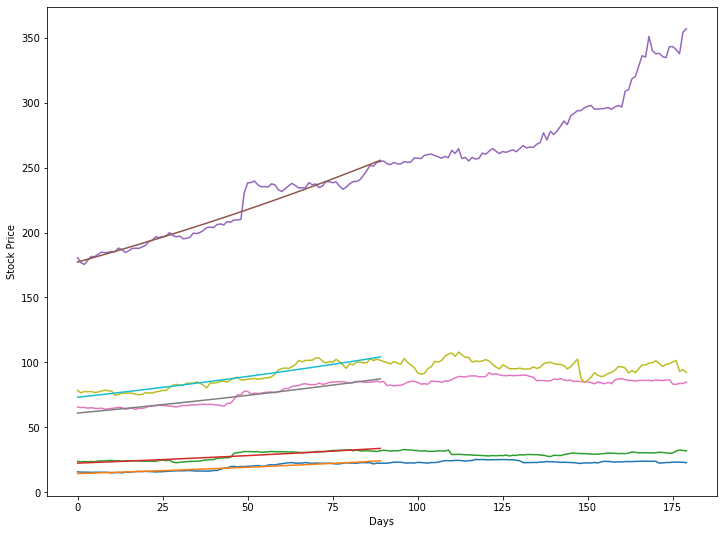

In [29]:
plt.figure(figsize=(12, 9))
plt.xlabel('Days')
plt.ylabel('Stock Price')

bests = momentums.max().sort_values(ascending=False).index[:5]
for best in bests:
    end = momentums[best].index.get_loc(momentums[best].idxmax())
    rets = np.log(stocks[best].iloc[end - 90 : end])
    x = np.arange(len(rets))
    slope, intercept, r_value, p_value, std_err = linregress(x, rets)
    plt.plot(np.arange(180), stocks[best][end-90:end+90])
    plt.plot(x, np.e ** (intercept + slope*x))

As we can see, the regression curves fit each stock pretty well; The stocks do not seem to follow the curve outside of the measurement window, but it is important to remember that this momentum indicator is only used for *ranking* the stocks, and is in no way trying to predict prices.

## Risk Parity Sizing

Clenow's strategy uses risk parity allocation to calculate the position sizes of each stock. Each stock is assigned a size using the following formula:

{% raw %}
$$Size = {{AccountValue\times RiskFactor} \over {{ATR}_{20}}}$$
{% endraw %}

Where ${ATR}_{20}$ is a stock's [Average True Range](https://www.investopedia.com/terms/a/atr.asp) over the past 20 days. The risk factor, in our case, will be 10 basis points (0.1%). This means that if we assume each stock's ATR remains similar in the future, we can expect each stock to have a daily impact of 0.1% of our portfolio. We are essentially normalizing the weights all of the stocks in our portfolio by risk.

Now that we understand how the strategy works, let's backtest it!

# Backtesting

First we'll code the `Momentum` indicator and our strategy:

In [32]:
import backtrader as bt

class Momentum(bt.Indicator):
    lines = ('trend',)
    params = (('period', 90),)
    
    def __init__(self):
        self.addminperiod(self.params.period)
    
    def next(self):
        returns = np.log(self.data.get(size=self.p.period))
        x = np.arange(len(returns))
        slope, _, rvalue, _, _ = linregress(x, returns)
        annualized = (1 + slope) ** 252
        self.lines.trend[0] = annualized * (rvalue ** 2)
        
        
class Strategy(bt.Strategy):
    def __init__(self):
        self.i = 0
        self.inds = {}
        self.spy = self.datas[0]
        self.stocks = self.datas[1:]
        
        self.spy_sma200 = bt.indicators.SimpleMovingAverage(self.spy.close,
                                                            period=200)
        for d in self.stocks:
            self.inds[d] = {}
            self.inds[d]["momentum"] = Momentum(d.close, 
                                                period=90)
            self.inds[d]["sma100"] = bt.indicators.SimpleMovingAverage(d.close, 
                                                                       period=100)
            self.inds[d]["atr20"] = bt.indicators.ATR(d, 
                                                      period=20)

    def prenext(self):
        # call next() even when data is not available for all tickers
        self.next()
    
    def next(self):
        if self.i % 5 == 0:
            self.rebalance_portfolio()
        if self.i % 10 == 0:
            self.rebalance_positions()
        self.i += 1
    
    def rebalance_portfolio(self):
        # only look at data that we can have indicators for 
        self.rankings = list(filter(lambda d: len(d) > 100, self.stocks))
        self.rankings.sort(key=lambda d: self.inds[d]["momentum"][0])
        num_stocks = len(self.rankings)
        
        # sell stocks based on criteria
        for i, d in enumerate(self.rankings):
            if self.getposition(self.data).size:
                if i > num_stocks * 0.2 or d < self.inds[d]["sma100"]:
                    self.close(d)
        
        if self.spy < self.spy_sma200:
            return
        
        # buy stocks with remaining cash
        for i, d in enumerate(self.rankings[:int(num_stocks * 0.2)]):
            cash = self.broker.get_cash()
            value = self.broker.get_value()
            if cash <= 0:
                break
            if not self.getposition(self.data).size:
                size = value * 0.001 / self.inds[d]["atr20"]
                self.buy(d, size=size)
                
        
    def rebalance_positions(self):
        num_stocks = len(self.rankings)
        
        if self.spy < self.spy_sma200:
            return

        # rebalance all stocks
        for i, d in enumerate(self.rankings[:int(num_stocks * 0.2)]):
            cash = self.broker.get_cash()
            value = self.broker.get_value()
            if cash <= 0:
                break
            size = value * 0.001 / self.inds[d]["atr20"]
            self.order_target_size(d, size)

As we can see in the code, the strategy looks for stocks it needs to sell every week in the `rebalance_portfolio` method and rebalances all of its positions every other week in the `rebalance_positions` method. Now let's run a backtest!

In [36]:
# from _notebooks.logging_stdout_file import *
# log = logging.getLogger('LOGGER_NAME')
# log.info("test")
from backtrader import date2num
cerebro = bt.Cerebro(stdstats=False)
cerebro.broker.set_coc(True)

spy = bt.feeds.YahooFinanceCSVData(dataname=f'{dir}/spy.csv', plot=False)
cerebro.adddata(spy)  # add S&P 500 Index

for ticker in tickers:
    df = pd.read_csv(f"{dir}/data/{ticker}.csv",
                     parse_dates=True,
                     index_col=0)
    if len(df) > 100: # data must be long enough to compute 100 day SMA
        cerebro.adddata(bt.feeds.PandasData(dataname=df, plot=False))

cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addstrategy(Strategy)
results = cerebro.run()

<IPython.core.display.Javascript object>

Sharpe: 0.940
Norm. Annual Return: 7.63%
Max Drawdown: 13.59%


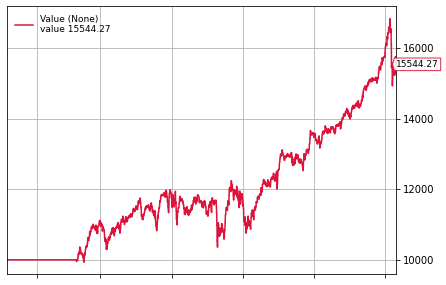

In [37]:
cerebro.plot(iplot=True)[0][0]
print(f"Sharpe: {results[0].analyzers.sharperatio.get_analysis()['sharperatio']:.3f}")
print(f"Norm. Annual Return: {results[0].analyzers.returns.get_analysis()['rnorm100']:.2f}%")
print(f"Max Drawdown: {results[0].analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")

As we can see the algorithm performs pretty well. It makes an average of almost 9% a year with a max drawdown of only 11%. Although the S&P 500 slightly outperforms the algorithm over this time period (CAGR of 12%), it does so with more volatility (Max Drawdown of 13.5%, Sharpe of 1.07). Overall, this algorithm provides a good base for a momentum strategy and can likely be improved by altering parameters, applying filters, and adding leverage. I would highly recommend reading Clenow's book [Stocks on the Move: Beating the Market with Hedge Fund Momentum Strategy](https://amzn.to/2YzEIvL), as it provides a much more in depth description as to how the algorithm works, as well as detailed analysis of how it has performed historically.

If you would like to try the the strategy for yourself, you can find [this notebook](https://github.com/teddykoker/blog/tree/master/notebooks) on my Github, along with my [survivorship bias-free dataset](https://github.com/teddykoker/quant/tree/master/survivorship-free)!